In [28]:
import glob
import cv2
import argparse
import torch
import numpy as np
import onnxruntime as ort
import os.path as osp

from utils import *

from types import SimpleNamespace
import matplotlib.pyplot as plt

from scipy.ndimage import rotate
from copy import deepcopy


args = SimpleNamespace()

args.dicom_dir = "/Users/qinyixin/Desktop/huaxi_proj/workspace/ADPD_Metrics/dicoms"
args.model_root = "/home/qinyixin/workspace/Swin-Unet/comp_project/models"
args.gpu = True
args.seg_image_size = 224
args.acpc_image_size = 256

### Data Loading & Normalization

In [30]:
### 读取原始图像 ###
dcm_p = glob.glob(args.dicom_dir + "/*")[0]
dcm_p = "/Users/qinyixin/Desktop/huaxi_proj/workspace/ADPD_Metrics/dicoms/0000070540"
original_image = load_dicom(dcm_p)
#original_image = sitk.ReadImage("/home/qinyixin/workspace/Swin-Unet/test_dicom/ADNI_002_S_0559_MR_MPR____N3__Scaled_Br_20070319121214158_S15922_I45126.nii")
norm_image = normalize(original_image)
image = sitk.GetArrayFromImage(norm_image)
visualize(image)

IndexError: list index out of range

### 尺度统一以及头动矫正 ###

/home/qinyixin/anaconda3/envs/huaxi/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
/home/qinyixin/anaconda3/envs/huaxi/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transfo

The offset angle is 0.17°


/home/qinyixin/anaconda3/envs/huaxi/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
  8%|▊         | 1/12 [00:00<00:02,  5.03it/s]/home/qinyixin/anaconda3/envs/huaxi/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
 25%|██▌       | 3/12 [00:00<00:01,  5.99it/s]/home/qinyixin/anaconda3/envs/huaxi/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
 58%|█████▊    | 7/12 [00:00<00:00, 10.10it/s]/home/qinyixin/anaconda3/envs/huaxi/lib/python3.10/site-packages/sklearn/svm/_

The offset angle is -5.62°


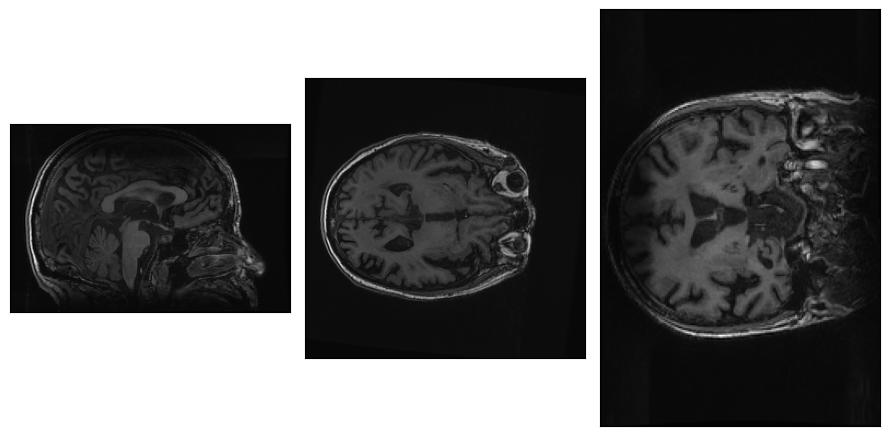

In [8]:
image = register(args, image)
image, mid_line = head_move(args, image)
visualize(image)

### 检测AC-PC

In [18]:
plt.imsave("/home/qinyixin/workspace/Swin-Unet/comp_project/new.png", acpc_slices[0], cmap= "gray")

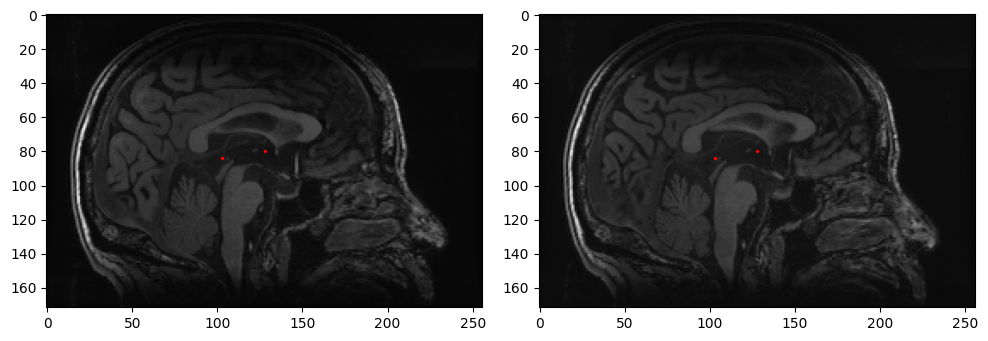

In [16]:
acpc_slices = image[mid_line -4: mid_line - 2, :, :]
points = find_acpc_line(args, acpc_slices)
visualize_multiple_images(acpc_slices, points = points)

In [5]:
if points[0] > points[2]:
    image = np.flip(image, axis=2)
    width = image.shape[-1]
    points[0] = width - points[0]
    points[2] = width - points[2]
image, new_points = adjust_acpc(points, image)

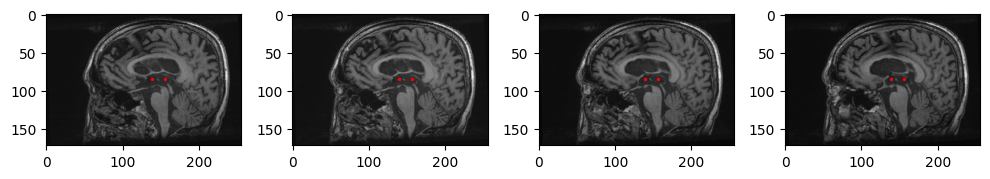

In [6]:
visualize_multiple_images(image[mid_line - 2: mid_line + 2, :, :], points = new_points)

### 分别根据AC和PC选取截面

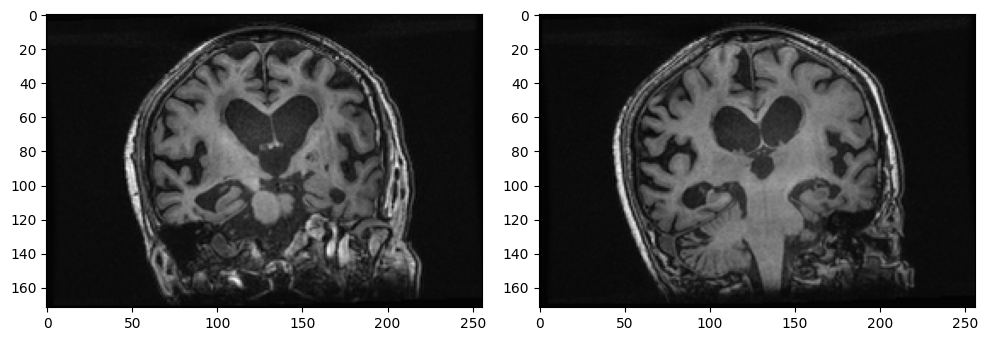

In [7]:
ac_slice = image[:, :, new_points[0]]
pc_slice = image[:, :, new_points[2]]

acpc_slices = np.stack([ac_slice, pc_slice])

acpc_slices = rotate(acpc_slices, angle = -90, axes=(1, 2))
visualize_multiple_images(acpc_slices)

### BVR & zEI

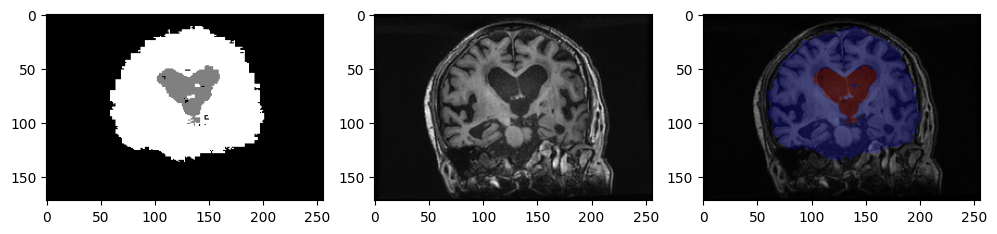

In [8]:
processor = get_unet_processor(224)
bvr_image = acpc_slices[0].copy()
ori_height, ori_width = bvr_image.shape
bvr_image = processor(bvr_image)
_, new_height, new_width = bvr_image.shape

provider = 'CUDAExecutionProvider' if args.gpu else 'CPUExecutionProvider'
model = ort.InferenceSession(osp.join(args.model_root, "bvr_seg.onnx"), providers=[provider])
outputs = model.run(None, {"input": bvr_image.unsqueeze(0).numpy()})[0]

outputs = torch.argmax(torch.softmax(torch.tensor(outputs), dim=1), dim=1)
outputs = outputs.data.cpu().numpy().squeeze()
restored_mask = zoom(outputs, (ori_height / 224, ori_width / 224), order=0)
restored_mask = np.clip(restored_mask, 0, 2)

#restored_mask = cv2.medianBlur(restored_mask.astype(np.uint8), 3)

restored_mask = post_process_seg(restored_mask.astype(np.uint8))

# restored_mask[restored_mask == 2] = 0
# num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(restored_mask, connectivity=8)
# area_threshold = 10
# for j in range(1, num_labels):
#     area = stats[j, cv2.CC_STAT_AREA]
#     if area <= area_threshold:
#         restored_mask[labels == j] = 1

visualize_multiple_images([restored_mask, acpc_slices[0], visualize_masks(acpc_slices[0], restored_mask)])
seg_image = restored_mask.copy()

zEI: 55 mm / 119 mm = 0.46218487394957986 
 BVR: 33 mm / 55 mm = 0.6


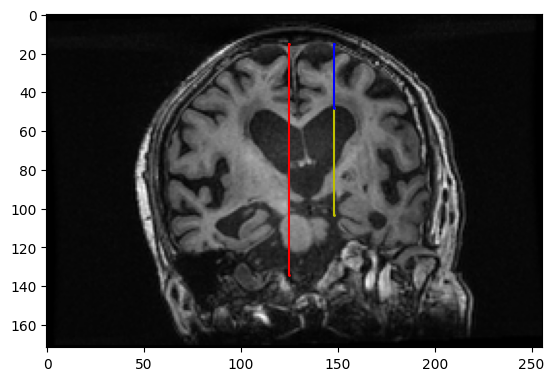

In [9]:
original_image = gray_to_rgb(acpc_slices[0].copy())
### for Highest line ###
head_height_indexes = np.argwhere(seg_image[:, mid_line] == 2)
head_height = head_height_indexes.max() - head_height_indexes.min()

plt.plot([mid_line, mid_line], [head_height_indexes.max(), head_height_indexes.min()],  marker = 'o', color = 'r', markersize = 1)

centroid = np.argwhere(seg_image == 1)
sorted_indices = np.argsort(centroid[:, 1])
sorted_array = centroid[sorted_indices]

l = len(sorted_array) // 2
left_ps, right_ps = sorted_array[:l], sorted_array[l:]

left_xs = left_ps[:, 0]
min_left_x, max_left_x = np.min(left_xs), np.max(left_xs)
min_left_y = left_ps[np.argwhere(left_ps[:,0] == min_left_x)][:, :, 1].mean()
### find min xs -> ys ###

right_xs = right_ps[:, 0]
min_right_x, max_right_x = np.min(right_xs), np.max(right_xs)
min_right_y = round(right_ps[np.argwhere(right_ps[:,0] == min_right_x)][:, :, 1].mean())

### find centorid height ###
if (max_left_x - min_left_x) > (max_right_x - min_right_x):
    pos_x, pos_y = min_left_x, min_left_y
    max_x = max_left_x
else:
    pos_x, pos_y = min_right_x, min_right_y
    max_x = max_right_x

centroid_height = max_x - pos_x
plt.plot([pos_y, pos_y], [pos_x, max_x],  marker = 'o', color = 'y', markersize = 1)

### calculate zEI ###
zEI = centroid_height / head_height
### calculate BVR ###
head_x = np.argwhere(seg_image[:, int(pos_y)] == 2).min()
head_gap = pos_x - head_x
BVR = head_gap / centroid_height

plt.plot([pos_y, pos_y], [pos_x, head_x],  marker = 'o', color = 'b', markersize = 1)

print(f"zEI: {centroid_height} mm / {head_height} mm = {zEI} \n BVR: {head_gap} mm / {centroid_height} mm = {BVR}")
plt.imshow(original_image)
plt.show()

### CA

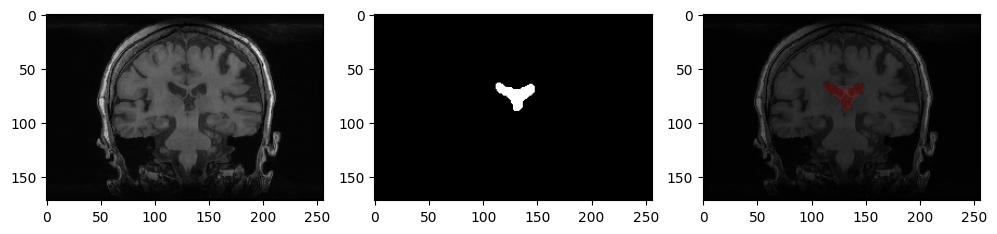

In [133]:
processor = get_unet_processor(224)
ori_ca_image = acpc_slices[1].copy()
ori_height, ori_width = ori_ca_image.shape
ca_image = processor(ori_ca_image)
_, new_height, new_width = ca_image.shape

provider = 'CUDAExecutionProvider' if args.gpu else 'CPUExecutionProvider'
model = ort.InferenceSession(osp.join(args.model_root, "ca_seg.onnx"), providers=[provider])
outputs = model.run(None, {"input": ca_image.unsqueeze(0).numpy()})[0]

outputs = torch.argmax(torch.softmax(torch.tensor(outputs), dim=1), dim=1)
outputs = outputs.data.cpu().numpy().squeeze()
restored_mask = zoom(outputs, (ori_height / 224, ori_width / 224), order=0)
restored_mask = np.clip(restored_mask, 0, 2)
restored_mask[restored_mask == 2] = 0
restored_mask = restored_mask.astype(np.uint8)

### post-process

# CA_mask = post_process_seg(restored_mask)
CA_mask = cv2.blur(restored_mask, (3, 3))
CA_mask = post_process_seg(CA_mask, 20)
visualize_multiple_images([ori_ca_image, CA_mask, visualize_masks(ori_ca_image, CA_mask)])

CA is 139.09°


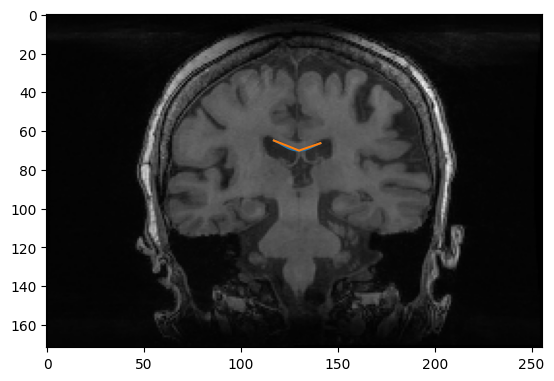

In [134]:
xs, ys = np.where(CA_mask == 1)
ys = set(ys.tolist())
ys = sorted(ys)
px, py =[], []
for y in ys:
    x_tmp = np.where(CA_mask[:, y] == 1)[0]
    if len(x_tmp) != 0:
        px.append(x_tmp.min())
        py.append(y)

coefficients = np.polyfit(np.array(py), np.array(px), 4)
p = np.poly1d(coefficients)

l_b, h_b = int(len(py) * 0.15), int(len(py) * 0.85)
py = py[l_b:h_b]
p_fit = p(py)
plt.plot(py, p_fit)
plt.imshow(gray_to_rgb(acpc_slices[1]))

x_max, max_index = np.max(p_fit), np.argmax(p_fit)
y_max = py[max_index]
left_xmin, right_xmin = np.min(p_fit[:max_index]), np.min(p_fit[max_index:])
#left_ymin = p_fit.index(left_xmin)
left_index = np.where(p_fit[:max_index] == left_xmin)[0].mean()
left_ymin = py[:max_index][int(left_index)]

right_index = np.where(p_fit[max_index:] == right_xmin)[0].mean()
right_ymin = py[max_index:][int(right_index)]


A, B, C = np.array([left_ymin, left_xmin]), np.array([y_max, x_max]), np.array([right_ymin, right_xmin])
BA, BC = A - B, C - B
dot_product = np.dot(BA, BC)

norm_BA = np.linalg.norm(BA)
norm_BC = np.linalg.norm(BC)
cos_theta = dot_product / (norm_BA * norm_BC)
cos_theta = np.clip(cos_theta, -1, 1)
    
theta_radians = np.arccos(cos_theta)
    
theta_degrees = np.degrees(theta_radians)

print("CA is {:.2f}°".format(theta_degrees))

plt.imshow(gray_to_rgb(acpc_slices[1]))
plt.plot([left_ymin, y_max, right_ymin], [left_xmin, x_max, right_xmin])
plt.show()

### Evans

In [135]:
provider = 'CUDAExecutionProvider' if args.gpu else 'CPUExecutionProvider'
EvansModel = ort.InferenceSession(osp.join(args.model_root, "judge_evans.onnx"), providers=[provider])
x, y, z = image.shape
low_bound, high_bound = int(0.3 * y), int(0.7 * y)
ori_y_images = image[:, low_bound:high_bound, :]
resnet_processor = get_resnet_processor(224, 3)

y_images = [resnet_processor(gray_to_rgb(ori_y_images[:, i, :])) for i in range(ori_y_images.shape[1])]
ori_y_images = np.stack([ori_y_images[:, i, :] for i in range(ori_y_images.shape[1])])


y_images = torch.stack(y_images)
logits = EvansModel.run(None, {'input':y_images.numpy()})[0]
positive_indexes = np.argmax(logits, axis = 1)

candidates = ori_y_images[positive_indexes == 1]

In [136]:
processor = get_unet_processor(224)
zEvans_image = rotate(candidates, -90, axes = (1, 2))
_, ori_height, ori_width = zEvans_image.shape
process_zEvans_image = torch.stack([processor(zEvans_image[i]) for i in range(len(zEvans_image))])
provider = 'CUDAExecutionProvider' if args.gpu else 'CPUExecutionProvider'
model = ort.InferenceSession(osp.join(args.model_root, "evans_seg.onnx"), providers=[provider])
model = ort.InferenceSession("/home/qinyixin/workspace/Swin-Unet/evans_seg.onnx", providers=[provider])
outputs = np.array([model.run(None, {"input": process_zEvans_image[i:i+1].numpy()})[0] for i in range(len(process_zEvans_image))])
outputs = torch.tensor(outputs).squeeze()
outputs = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
outputs = outputs.data.cpu().numpy()

restored_mask = zoom(outputs, (1, ori_height / 224, ori_width / 224), order=0)
restored_mask = np.clip(restored_mask, 0, 2)
restored_mask = restored_mask.astype(np.uint8)

### post process ###
for i in range(len(restored_mask)):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(restored_mask[i])
    area_threshold = 10
    for j in range(1, num_labels):
        area = stats[j, cv2.CC_STAT_AREA]
        if area <= area_threshold:
            restored_mask[i][labels == j] = 0

### Center: 2  Boundary: 1

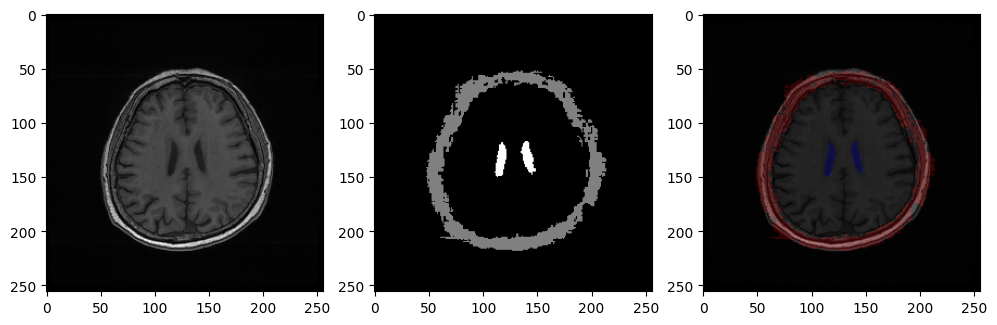

In [137]:
### scan center
center_mask = deepcopy(restored_mask) 
center_mask[center_mask == 1] = 0

max_center_id = -1
max_center_length = 0
c_maxh, c_minh, c_maxw, c_minw = 0, 0, 0, 0
for i in range(len(center_mask)):
    c_mask = center_mask[i]
    c_mask = cv2.medianBlur(c_mask, 3)

    c_tmp = np.nonzero(c_mask)
    x_axis = list(set(c_tmp[0]))
    crop_x = (max(x_axis) - min(x_axis))//3 + min(x_axis)
    
    c_mask = c_mask[:crop_x, :]
    axis_x = set(np.nonzero(c_mask)[0].tolist())

    for x in axis_x:
        row = c_mask[x]
        tmp_row = np.nonzero(row)[0]
        interval = tmp_row.max() - tmp_row.min()
        if interval > max_center_length:
            max_center_length = interval
            c_minw, c_maxw = tmp_row.min(), tmp_row.max()
            c_minh = c_maxh = x
            max_center_id = i

ei_image = np.rot90(candidates[max_center_id], -1)
ei_mask = restored_mask[max_center_id]
visualize_multiple_images([ei_image, ei_mask, visualize_masks(ei_image, ei_mask)])


Evans is : 29mm / 140mm = 0.20714285714285716


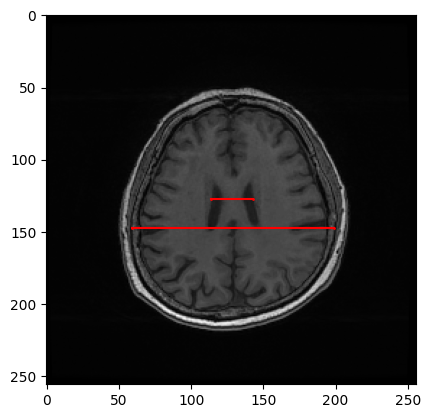

In [138]:
boundary_mask = deepcopy(restored_mask)   
boundary_mask = boundary_mask[max_center_id]
boundary_mask[boundary_mask == 2] = 0

b_mask = post_process_seg(boundary_mask, 50)
b_mask = cv2.blur(b_mask, (5, 5))

b_tmp = np.nonzero(b_mask)
x_axis = list(set(b_tmp[0]))
max_boundary_length = 0
b_maxh, b_minh, b_maxw, b_minw = 0, 0, 0, 0
for x in x_axis:
    row = b_mask[x]
    tmp_row = np.nonzero(row)[0]
    center_line = (tmp_row.min() + tmp_row.max()) // 2
    
    left_nonzero, right_nonzero = np.nonzero(row[:center_line])[0], np.nonzero(row[center_line:])[0]
    if len(left_nonzero) == 0 or len(right_nonzero) == 0:
        continue

    left_max = left_nonzero.max()
    right_min = right_nonzero.min()
    
    interval = right_min - left_max + center_line
    if interval > max_boundary_length:
        max_boundary_length = interval
        b_minw, b_maxw = left_max, right_min + center_line
        b_minh = b_maxh = x


plt.imshow(np.rot90(candidates[max_center_id], -1), cmap = "gray")
plt.plot([c_maxw, c_minw], [c_maxh, c_minh],  marker = 'o', color = 'r', markersize = 1)
plt.plot([b_maxw, b_minw], [b_maxh, b_minh],  marker = 'o', color = 'r', markersize = 1)

print(f"Evans is : {max_center_length}mm / {max_boundary_length}mm = {max_center_length / max_boundary_length}")

In [10]:
re.search(r'\d+', "0_107.jpg").group()

'0'

In [12]:
import os
import re
from functools import cmp_to_key
image_names = [i +"\n" for i in os.listdir("/Users/qinyixin/Desktop/recog_z")]

def func(x, y):
    nums_x = re.findall(r'\d+', x)
    nums_x0 = int(nums_x[0])
    nums_x1 = int(nums_x[1])

    nums_y = re.findall(r'\d+', y)
    nums_y0 = int(nums_y[0])
    nums_y1 = int(nums_y[1])

    if nums_y0 != nums_x0:
        return nums_x0 - nums_y0
    else:
        return nums_x1 - nums_y1

image_names = sorted(image_names, key=cmp_to_key(func))
#open("segz.txt", "w").writelines(image_names)

In [14]:
neg = open("segz.txt").readlines()

pos = [i for i in image_names if i not in neg]

In [16]:
with open("pos.txt", "w") as f:
    f.writelines(pos)

In [27]:
from utils import *

model = ort.InferenceSession("/Users/qinyixin/Desktop/huaxi_proj/workspace/ADPD_Metrics/models/brain_seg_z.onnx")
processor = get_unet_processor()
for im in neg:
    idx = int(im.split("_")[0])
    if idx > 9:
        break

    im = osp.join("/Users/qinyixin/Desktop/recog_z", im.strip())
    image = cv2.imread(im, 0)
    process_image = processor(image)
    outputs = model.run(None, {"input":process_image.unsqueeze(0).numpy()})[0]
    outputs = torch.tensor(outputs)
    outputs = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
    outputs = outputs.data.cpu().numpy().squeeze()

    x, y = image.shape
    ### 将得到的mask恢复到原始尺度
    mask = zoom(outputs, (x / 224, y / 224), order=1)
    mask = np.clip(mask, 0, 2)

    masks = visualize_masks(image, mask)
    plt.imsave("visualize_neg/" + osp.basename(im), masks)
